In [1]:
import numpy as np
import pandas as pd

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None
(144, 1)


<Axes: xlabel='Month'>

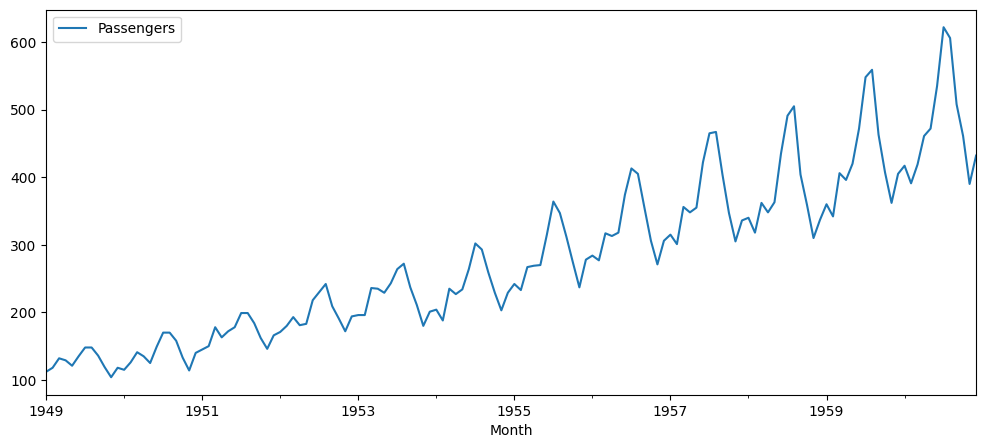

In [34]:
dataset = pd.read_csv('/content/airline-passengers.csv', index_col = [0], parse_dates = True, engine = 'python')
print(dataset.info())
print(dataset.shape)
dataset.head()
dataset.plot(figsize = (12,5))

In [33]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

tf.random.set_seed(7)

In [35]:
dataset = dataset.values.astype('float32')

In [37]:
scaler = MinMaxScaler(feature_range = (0,1))
dataset = scaler.fit_transform(dataset)

In [39]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size

train, test = dataset[:train_size,:], dataset[train_size:,:]
print(len(train), len(test))

108 36


In [48]:
# Converting an Array of Values into a Dataset Matrix

def create_dataset(dataset, look_back: int=1) -> tuple:
  dataX, dataY = list(), list()

  for i in range(len(dataset) - look_back):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i+look_back, 0])

  return np.array(dataX), np.array(dataY)

In [57]:
look_back = 1 # Timesteps
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [64]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])) # samples:107, win_size:1, n_feat:1
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# Fitting
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 100, batch_size = 1, verbose = 2)

In [67]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

print('Train Score(RMSE): %.2f ' %trainScore)
print('Train Score(R2): %.2f' %r2_score(trainY[0], trainPredict[:,0]))
print('Test Score(RMSE): %.2f ' %testScore)
print('Test Score(R2): %.2f' %r2_score(testY[0], testPredict[:,0]))

2/2 [==============================] - 0s 3ms/step
Train Score(RMSE): 25.22 
Train Score(R2): 0.91
Test Score(RMSE): 52.22 
Test Score(R2): 0.55


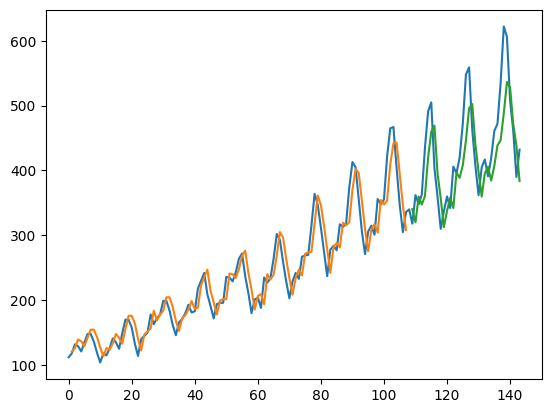

In [107]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict #107까지 valid

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-(len(testPredict)):, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()